Here we will test our single view models and our multiview model using the generated data.

In [5]:
import os
import keras
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from transformers import AutoTokenizer, TFAutoModel
import tensorflow_datasets as tfds
from keras.datasets import mnist 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, f1_score, accuracy_score

from PIL import Image
from keras.callbacks import EarlyStopping
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.models import Model

from utils import show_performance_metrics, preprocess_image, augment_image, apply_augmentation
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# --- Configuration ---
# Image dimensions for ResNet50 input
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3 # ResNet50 expects 3 channels (RGB)

# Batch size for training
BATCH_SIZE = 16 

# Number of epochs for training the classifier head
EPOCHS = 30

# Learning rate for the classifier head
LEARNING_RATE = 1e-4

# Seed used for splitting the train, validation and test dataset 
seed = 5

In [7]:
# ---  Data Loading from CSV ---
# Load CSV file
try:
    df = pd.read_csv('../handwriting_generation/dyslexia_handwriting_dataset.csv')
    print("--- Successfully loaded dyslexia_handwriting_dataset.csv ---")
except FileNotFoundError:
    print("Error: 'dyslexia_handwriting_dataset.csv' not found. Please ensure the CSV file is in the same directory as the script.")
    exit()

if 'file_path' not in df.columns or 'text' not in df.columns or 'presence_of_dyslexia' not in df.columns:
    print("Error: CSV must contain 'file_path', 'text', and 'presence_of_dyslexia' columns.")
    exit()

# Convert labels to integer type
df['presence_of_dyslexia'] = df['presence_of_dyslexia'].astype(int)

print("--- DataFrame Head ---")
print(df.head())
print("\n--- Value Counts for Dyslexia Presence ---")
print(df['presence_of_dyslexia'].value_counts())

--- Successfully loaded dyslexia_handwriting_dataset.csv ---
--- DataFrame Head ---
   presence_of_dyslexia                                          file_path  \
0                     0  ../data/normal_handwriting_images/normal_sampl...   
1                     0  ../data/normal_handwriting_images/normal_sampl...   
2                     0  ../data/normal_handwriting_images/normal_sampl...   
3                     0  ../data/normal_handwriting_images/normal_sampl...   
4                     0  ../data/normal_handwriting_images/normal_sampl...   

                                                text  
0  My best friend, Violet, has a navy pet hedgeho...  
1  My best friend, Kevin, has a silver pet parrot...  
2  My best friend, George, has a navy pet fish. G...  
3  My best friend, Mia, has a gold pet budgie. Mi...  
4  My best friend, Laura, has a yellow pet hamste...  

--- Value Counts for Dyslexia Presence ---
presence_of_dyslexia
0    500
1    500
Name: count, dtype: int64


Create New dataset which will balanced, the label 1 images + text will be the same as the original generated dataset.

The label 0 images + text will have dyslexic handwriting in the image but the text will be non-dyslexic, this will be to emulate moto dysgraphia which affects the fine motor skills needed for handwriting. Individuals with motor dysgraphia struggle with the physical act of writing, including holding a pencil correctly, forming letters, and maintaining consistent letter size and spacing. Motor-dysgraphics struggle with proper finger grip and often writing is slanted due to incorrect holding of the pen.

# 1  Single View model Using Images


Total files: 1000
Training files: 700 (70.0%)
Validation files: 150 (15.0%)
Test files: 150 (15.0%)

--- tf.data.Dataset created successfully ---

--- Model Summary (Initial Frozen Layers) ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- Training the model for 30 epochs ---
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - accuracy: 0.8256 - loss: 0.3530 - val_accuracy: 0.9867 - val_loss: 0.0447
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.9801 - loss: 0.0433 - val_accuracy: 0.9867 - val_loss: 0.0396
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.9848 - loss: 0.0558 - val_accuracy: 0.9933 - val_loss: 0.0207
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.9931 - loss: 0.0217 - val_accuracy: 1.0000 - val_loss: 0.0153
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.9937 - loss: 0.0209 - val_accuracy: 0.9933 - val_loss: 0.0173
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.9980 - loss: 0.0083 - val_accuracy: 0.9733 - val_loss: 0.0540
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.9900 - loss: 0.0338 - val_accuracy: 1.0000 - val_loss: 0.0143
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accurac

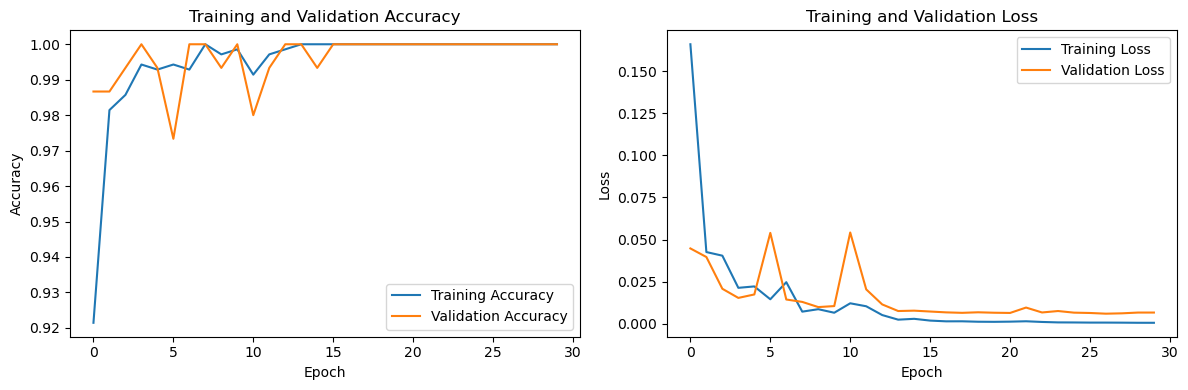


Confusion Matrix:


2025-08-23 10:25:53.744099: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


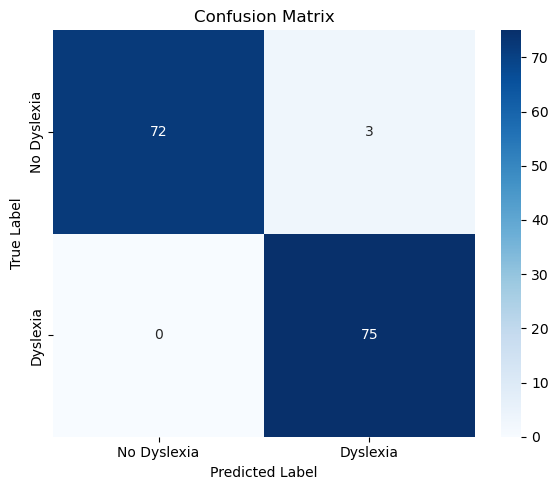


Additional Metrics for Test Results:
Sensitivity (Recall): 1.0000
Specificity: 0.9600
F1 Score: 0.9804

Classification Report:
              precision    recall  f1-score   support

 No Dyslexia       1.00      0.96      0.98        75
    Dyslexia       0.96      1.00      0.98        75

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150

ROC AUC Score (Prob-based): 0.9973
PR AUC Score: 0.9972


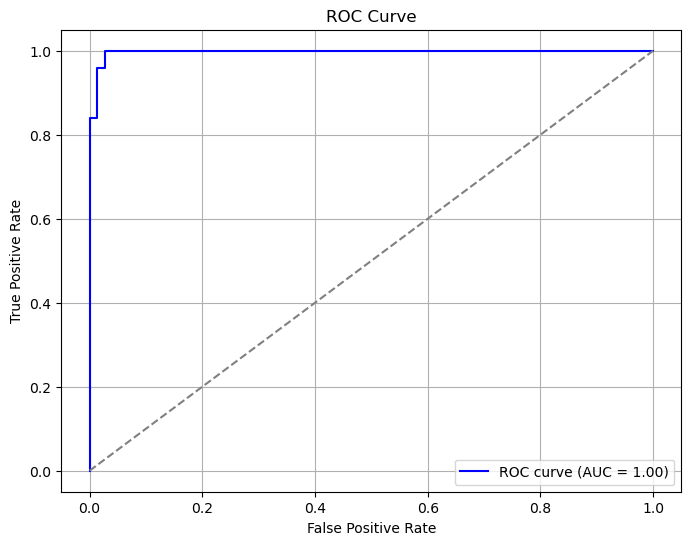

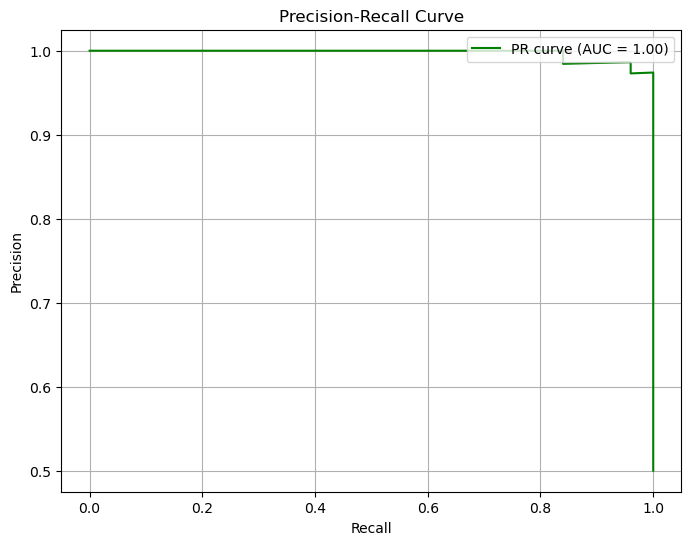

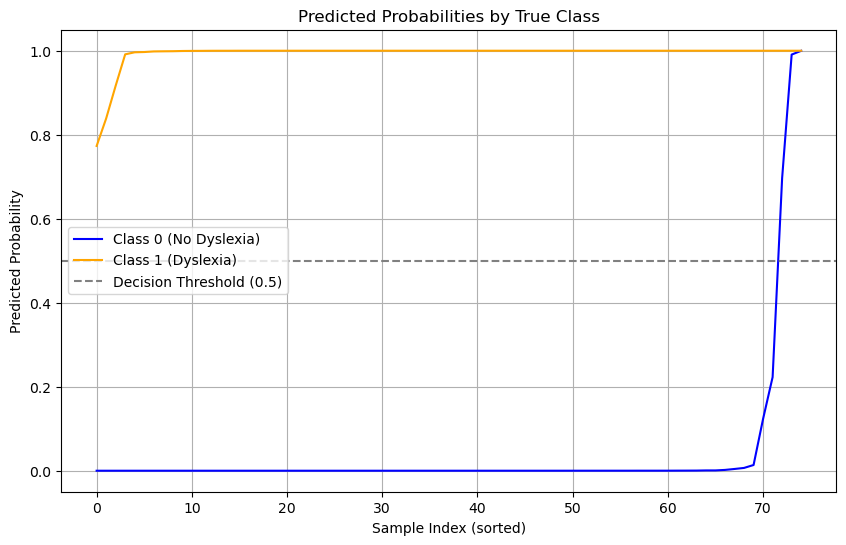

In [8]:
# Create Single View model using handwriting images 

# ---  Data Splitting ---
# 70% Training, 15% Validation, 15% Testing

# Split into training and (validation + test)
train_df, val_test_df = train_test_split(
    df,
    test_size=0.3, 
    stratify=df['presence_of_dyslexia'], # Maintain class distribution
    random_state=seed
)

# Then, split (validation + test) into validation and test
val_df, test_df = train_test_split(
    val_test_df,
    test_size=0.5, 
    stratify=val_test_df['presence_of_dyslexia'], # Maintain class distribution
    random_state=seed
)

print(f"\nTotal files: {len(df)}")
print(f"Training files: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation files: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test files: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

# --- Image Preprocessing and tf.data.Dataset creation ---
# Create tf.data.Dataset from DataFrames
def create_dataset(dataframe, augment=False, shuffle=False):
    # Convert file_path and presence_of_dyslexia columns to TensorFlow tensors
    file_paths = tf.constant(dataframe['file_path'].tolist())
    labels = tf.constant(dataframe['presence_of_dyslexia'].tolist(), dtype=tf.float32) 

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe), seed=seed)

    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE) # Prefetch for performance
    return dataset

train_dataset_image = create_dataset(train_df, augment=False, shuffle=True)
validation_dataset_image = create_dataset(val_df, augment=False, shuffle=False)
test_dataset_image = create_dataset(test_df, augment=False, shuffle=False)

print("\n--- tf.data.Dataset created successfully ---")

# --- Model Building (ResNet50 for Binary Classification) ---
# Load ResNet50 model with pre-trained ImageNet weights, excluding the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model layers to prevent their weights from being updated during initial training.
# This uses the pre-learned features from ImageNet as-is.
base_model.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces spatial dimensions to 1x1, capturing global features
x = Dense(256, activation='relu')(x) # A dense layer before the final output
predictions = Dense(1, activation='sigmoid')(x) # Output layer for binary classification

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
# Using Adam optimizer, binary_crossentropy for binary classification, and accuracy as metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("\n--- Model Summary (Initial Frozen Layers) ---")
model.summary()

# --- Model Training ---

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
print(f"\n--- Training the model for {EPOCHS} epochs ---")
history = model.fit(
    train_dataset_image,
    epochs=EPOCHS,
    validation_data=validation_dataset_image,
    callbacks=[early_stopping_callback]
)

# ---  Model Evaluation ---
print("\n--- Evaluating the model on the test set ---")
test_loss, test_accuracy = model.evaluate(test_dataset_image)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# ---  Visualize Training History ---
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
# --- Gather predictions and true labels ---
all_probs = []
all_labels = []

for images, labels in test_dataset_image:
    probs = model.predict(images, verbose=0).flatten()
    all_probs.extend(probs)
    all_labels.extend(labels.numpy())

# --- Show final performance metrics ---
show_performance_metrics(all_labels, all_probs)


# 2  Single View model using transcript text 

Loading BERT tokenizer and tokenizing all text...


/config/anaconda3/envs/imperial_3_12_linux/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


All text tokenized. Input IDs shape: (1000, 128), Attention Masks shape: (1000, 128)
Training samples: 700
Validation samples: 150
TensorFlow Datasets created from preprocessed NumPy arrays for text.
Building single-view text model architecture...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

BERT model wrapped in custom layer and layers frozen.
Compiling text model...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_feature_extra… │ (None, 768)       │          0 │ attention_mask[0… │
│ (BertEmbeddingLaye… │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    196,864 │ bert_feature_ext… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        257 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 197,121 (770.00 KB)

 Trainable params: 197,121 (770.00 KB)

 Non-trainable params: 0 (0.00 B)

Training text model...
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 509ms/step - accuracy: 0.5147 - loss: 0.7345 - val_accuracy: 0.9733 - val_loss: 0.3156
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 490ms/step - accuracy: 0.9192 - loss: 0.3325 - val_accuracy: 0.9733 - val_loss: 0.1892
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step - accuracy: 0.9416 - loss: 0.2457 - val_accuracy: 0.9733 - val_loss: 0.1456
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step - accuracy: 0.9495 - loss: 0.1890 - val_accuracy: 0.9733 - val_loss: 0.1248
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step - accuracy: 0.9528 - loss: 0.1640 - val_accuracy: 0.9733 - val_loss: 0.1141
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step - accuracy: 0.9538 - loss: 0.1578 - val_accuracy: 0.9733 - val_loss: 0.1054
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step - accuracy: 0.9518 - loss: 0.1549 - val_accuracy: 0.9733 - val_loss: 0.1004
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 490ms/step - accuracy: 0.9559 - 

2025-08-23 10:36:55.732208: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


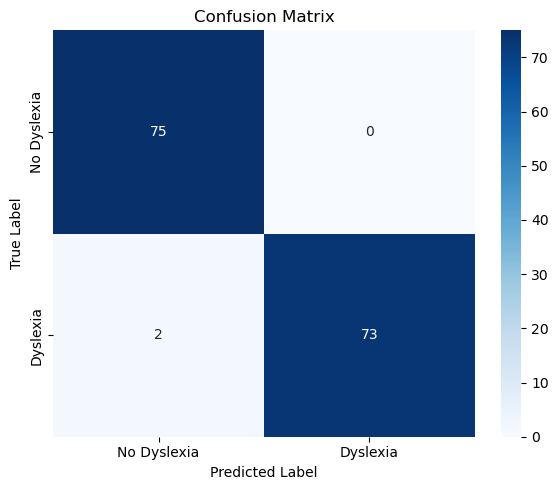


Additional Metrics for Test Results:
Sensitivity (Recall): 0.9733
Specificity: 1.0000
F1 Score: 0.9865

Classification Report:
              precision    recall  f1-score   support

 No Dyslexia       0.97      1.00      0.99        75
    Dyslexia       1.00      0.97      0.99        75

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

ROC AUC Score (Prob-based): 0.9863
PR AUC Score: 0.9915


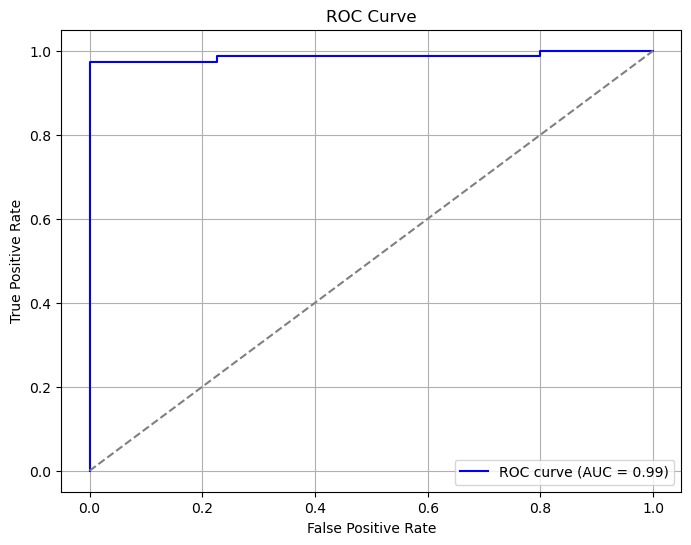

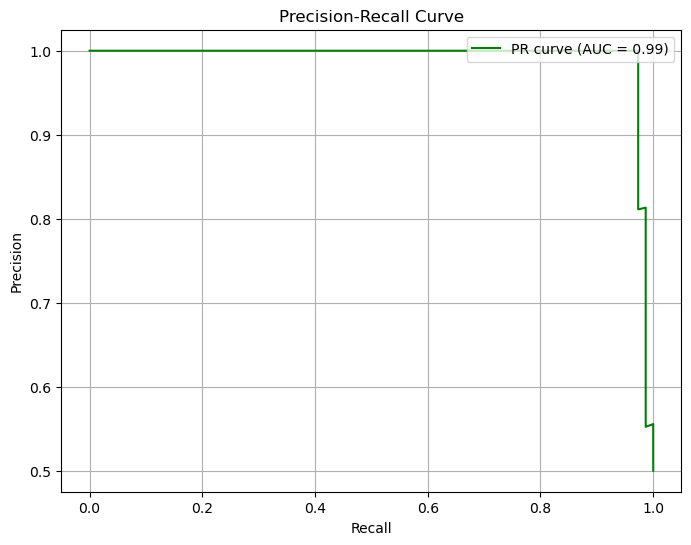

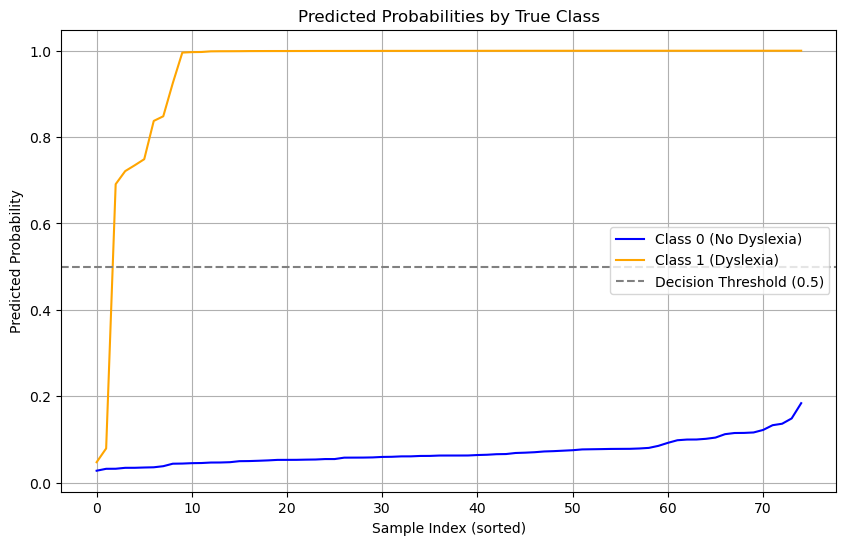


Text single-view model training and evaluation complete.


In [9]:
# Create Single View model using transcript text 
# --- Text Tokenization (Pre-tokenizing all text) ---
print("Loading BERT tokenizer and tokenizing all text...")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased") 
all_input_ids = []
all_attention_masks = []

for text_entry in df['text']:
    encoded_input = tokenizer(
        text_entry,
        padding='max_length',
        truncation=True,
        max_length=128,  
        return_tensors='np'  
    )
    all_input_ids.append(encoded_input['input_ids'][0])
    all_attention_masks.append(encoded_input['attention_mask'][0])

all_input_ids = np.array(all_input_ids)
all_attention_masks = np.array(all_attention_masks)
print(f"All text tokenized. Input IDs shape: {all_input_ids.shape}, Attention Masks shape: {all_attention_masks.shape}")

# ---  Split Processed data: 70% Train, 15% Validation, 15% Test for Text Data ---
X_input_ids_train, X_input_ids_temp, \
X_attention_masks_train, X_attention_masks_temp, \
y_train, y_temp = train_test_split(
    all_input_ids,
    all_attention_masks,
    df['presence_of_dyslexia'].values,
    test_size=0.3,
    random_state=seed,
    stratify=df['presence_of_dyslexia'].values # Stratify based on the full labels
)

#  Split the Temporary set (30%) into Validation (15%) and Test (15%)
X_input_ids_val, X_input_ids_test, \
X_attention_masks_val, X_attention_masks_test, \
y_val, y_test = train_test_split(
    X_input_ids_temp,
    X_attention_masks_temp,
    y_temp, 
    test_size=0.5,   
    random_state=seed,  
    stratify=y_temp # Crucial: Stratify based on the labels from the temp set
)

print(f"Training samples: {len(y_train)}")
print(f"Validation samples: {len(y_val)}")

# --- Create TensorFlow Datasets from NumPy arrays (for text only) ---
def create_tf_text_dataset_from_np(input_ids, attention_masks, labels):
    """
    Creates a TensorFlow Dataset from NumPy arrays for text data.
    """
    ds = tf.data.Dataset.from_tensor_slices(
        (
            {'input_ids': input_ids, 'attention_mask': attention_masks},
            labels
        )
    )
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset_text = create_tf_text_dataset_from_np(X_input_ids_train, X_attention_masks_train, y_train)
val_dataset_text = create_tf_text_dataset_from_np(X_input_ids_val, X_attention_masks_val, y_val)
test_dataset_text = create_tf_text_dataset_from_np(X_input_ids_test, X_attention_masks_test, y_test)

print("TensorFlow Datasets created from preprocessed NumPy arrays for text.")

# --- Custom Keras Layer for BERT Model (re-used from multi-view) ---
class BertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, model_name, **kwargs):
        super().__init__(**kwargs)
        self.bert_model = TFAutoModel.from_pretrained(model_name, from_pt=True) 
        self.bert_model.trainable = False # Keep BERT layers frozen for feature extraction

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        # The training=False argument is crucial to prevent issues with symbolic tensors
        bert_output = self.bert_model(input_ids, attention_mask=attention_mask, training=False)
        # The [CLS] token output is typically at index 0 of the last_hidden_state
        return bert_output.last_hidden_state[:, 0, :]

    def get_config(self):
        config = super().get_config()
        config.update({"model_name": "bert-base-cased"})  
        return config

# --- Define the Single-View Text Model ---
print("Building single-view text model architecture...")

# Text Branch (BERT) using the custom layer
bert_input_ids = keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
bert_attention_mask = keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

bert_embedding_extractor = BertEmbeddingLayer("bert-base-cased", name="bert_feature_extractor") 
text_features = bert_embedding_extractor({'input_ids': bert_input_ids, 'attention_mask': bert_attention_mask})
print("BERT model wrapped in custom layer and layers frozen.")

# Classifier Head (New layers to be trained)
classifier_head = layers.Dense(256, activation='relu')(text_features)
classifier_head = layers.Dropout(0.5)(classifier_head)
'''classifier_head = layers.Dense(128, activation='relu')(classifier_head)
classifier_head = layers.Dropout(0.3)(classifier_head)'''
output_layer = layers.Dense(1, activation='sigmoid', name='output')(classifier_head)

# Create the final single-view text model
text_model = keras.Model(
    inputs={'input_ids': bert_input_ids, 'attention_mask': bert_attention_mask},
    outputs=output_layer
)

# --- Compile and Train the Text Model ---
print("Compiling text model...")
text_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

text_model.summary()

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("Training text model...")
history_text = text_model.fit(
    train_dataset_text,
    epochs=EPOCHS,
    validation_data=val_dataset_text,
    callbacks=[early_stopping_callback]
)

# --- Evaluation for Text Model ---
print("\nEvaluating text model on validation set...")
test_loss_text, test_accuracy_text = text_model.evaluate(test_dataset_text)
print(f"Text Model Test Loss: {test_loss_text:.4f}")
print(f"Text Model Test Accuracy: {test_accuracy_text:.4f}")

# Generate predictions and classification report for text model
all_preds_text = []
all_labels_text = []
# Create a dataset for prediction from validation data for text
predict_dataset_text = tf.data.Dataset.from_tensor_slices(
    (
        {'input_ids': X_input_ids_test, 'attention_mask': X_attention_masks_test},
        y_test
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for inputs, labels in predict_dataset_text:
    predictions = text_model.predict(inputs)
    all_preds_text.extend(predictions.flatten().tolist())
    all_labels_text.extend(labels.numpy().flatten().tolist())

# Convert probabilities to binary predictions (0 or 1)
binary_preds_text = np.array(all_preds_text) > 0.5

print("\nClassification Report (Text Model):")
print(classification_report(all_labels_text, binary_preds_text))

print("\nConfusion Matrix (Text Model):")
print(confusion_matrix(all_labels_text, binary_preds_text))

# --- Show final performance metrics ---
show_performance_metrics(all_labels_text, all_preds_text)

print("\nText single-view model training and evaluation complete.")

# 3 Multiview model using both handwriting and transcript text 

Total samples: 1000
Loading and preprocessing all images...
All images loaded. Shape: (1000, 224, 224, 3)
Loading BERT tokenizer and tokenizing all text...
All text tokenized. Input IDs shape: (1000, 128), Attention Masks shape: (1000, 128)


/config/anaconda3/envs/imperial_3_12_linux/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Training samples: 700
Validation samples: 150
Test samples: 150
TensorFlow Datasets created from preprocessed NumPy arrays.
Building multi-modal model architecture...
ResNet50 model loaded and layers frozen.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

BERT model wrapped in custom layer and layers frozen.
Compiling model...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ image_input[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,473,345 (100.99 MB)

 Trainable params: 2,885,633 (11.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Training model...
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 702ms/step - accuracy: 0.7604 - loss: 0.4879 - val_accuracy: 0.9933 - val_loss: 0.0475
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 663ms/step - accuracy: 0.9907 - loss: 0.0445 - val_accuracy: 0.9933 - val_loss: 0.0283
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 660ms/step - accuracy: 0.9906 - loss: 0.0288 - val_accuracy: 0.9800 - val_loss: 0.0320
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 662ms/step - accuracy: 0.9964 - loss: 0.0227 - val_accuracy: 0.9933 - val_loss: 0.0214
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 661ms/step - accuracy: 0.9966 - loss: 0.0210 - val_accuracy: 0.9867 - val_loss: 0.0227
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 662ms/step - accuracy: 0.9797 - loss: 0.0406 - val_accuracy: 0.9933 - val_loss: 0.0152
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 665ms/step - accuracy: 0.9970 - loss: 0.0129 - val_accuracy: 0.9933 - val_loss: 0.0143
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 662ms/step - accuracy: 0.9961 - loss:

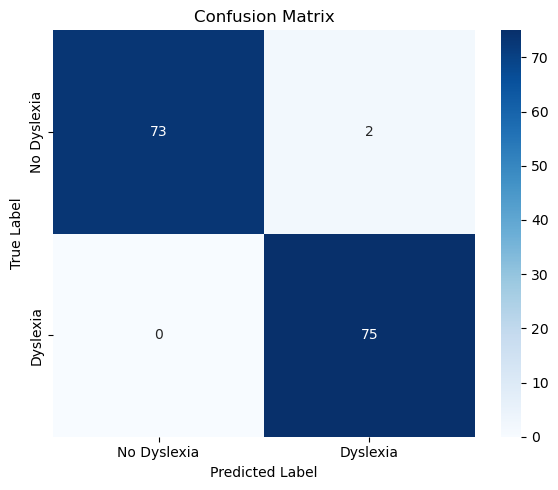


Additional Metrics for Test Results:
Sensitivity (Recall): 1.0000
Specificity: 0.9733
F1 Score: 0.9868

Classification Report:
              precision    recall  f1-score   support

 No Dyslexia       1.00      0.97      0.99        75
    Dyslexia       0.97      1.00      0.99        75

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

ROC AUC Score (Prob-based): 0.9995
PR AUC Score: 0.9995


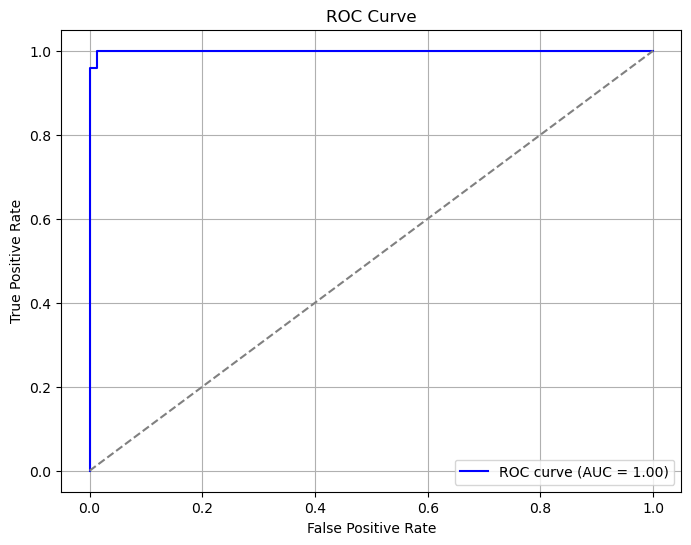

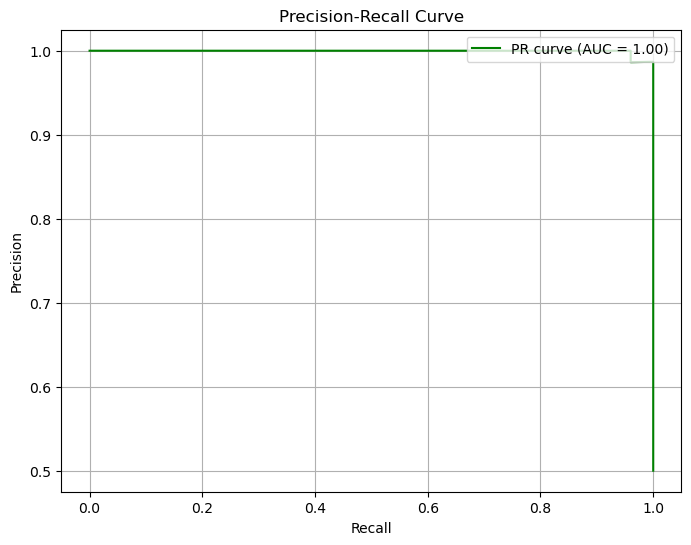

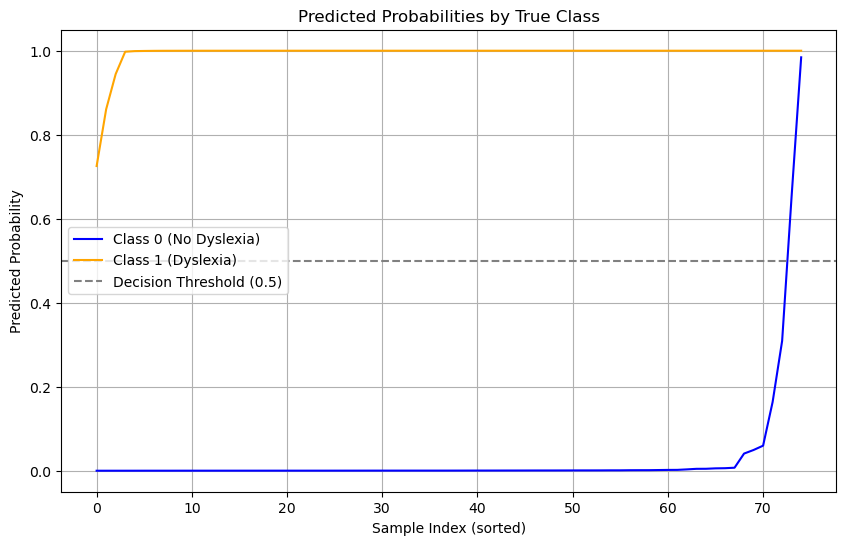


Model training and evaluation complete.


In [10]:
# Create MultiView model using both handwriting and transcript text 
df['text'] = df['text'].fillna('').astype(str) # Fill NaN with empty string, then convert to str
print(f"Total samples: {len(df)}")

# --- Image Preprocessing (Pre-loading all images) ---
print("Loading and preprocessing all images...")
all_images = []
for index, row in df.iterrows():
    image_path = row['file_path']
    full_image_path = image_path 
    try:
        # Load image file
        img = tf.io.read_file(full_image_path)
        # Decode image 
        img = tf.image.decode_jpeg(img, channels=3)  
        # Resize image
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        # Apply ResNet50 specific preprocessing
        img = tf.keras.applications.resnet50.preprocess_input(img)
        all_images.append(img)
    except Exception as e:
        print(f"Error loading image {full_image_path}: {e}. Appending black image placeholder.")
        all_images.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32))

all_images = np.array(all_images)
print(f"All images loaded. Shape: {all_images.shape}")

# --- Text Tokenization (Pre-tokenizing all text) ---
print("Loading BERT tokenizer and tokenizing all text...")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

all_input_ids = []
all_attention_masks = []

for text_entry in df['text']:
    encoded_input = tokenizer(
        text_entry,  
        padding='max_length',
        truncation=True,
        max_length=128, # Consistent max length
        return_tensors='np'  
    )
    # Access the first (and only) item in the batch dimension [0]
    all_input_ids.append(encoded_input['input_ids'][0])
    all_attention_masks.append(encoded_input['attention_mask'][0])

all_input_ids = np.array(all_input_ids)
all_attention_masks = np.array(all_attention_masks)
print(f"All text tokenized. Input IDs shape: {all_input_ids.shape}, Attention Masks shape: {all_attention_masks.shape}")

#  Split into Training (70%) and Temporary (30%)
X_images_train, X_images_temp, \
X_input_ids_train, X_input_ids_temp, \
X_attention_masks_train, X_attention_masks_temp, \
y_train, y_temp = train_test_split(
    all_images,
    all_input_ids,
    all_attention_masks,
    df['presence_of_dyslexia'].values,
    test_size=0.3,  
    random_state=seed,
    stratify=df['presence_of_dyslexia'].values
)

#  Split the Temporary set (30%) into Validation (15%) and Test (15%)
X_images_val, X_images_test, \
X_input_ids_val, X_input_ids_test, \
X_attention_masks_val, X_attention_masks_test, \
y_val, y_test = train_test_split(
    X_images_temp,
    X_input_ids_temp,
    X_attention_masks_temp,
    y_temp,
    test_size=0.5, 
    random_state=seed, 
    stratify=y_temp # Stratify based on the labels of the temp set
)

print(f"Training samples: {len(y_train)}")
print(f"Validation samples: {len(y_val)}")
print(f"Test samples: {len(y_val)}")

# --- Create TensorFlow Datasets from NumPy arrays ---
def create_tf_dataset_from_np(images, input_ids, attention_masks, labels, augment=False, shuffle=False, buffer_size=1000):
    """
    Creates a TensorFlow Dataset from NumPy arrays.
    Applies augmentation as a TensorFlow operation if specified.
    """
    ds = tf.data.Dataset.from_tensor_slices(
        (
            {'image_input': images, 'input_ids': input_ids, 'attention_mask': attention_masks},
            labels
        )
    )

    if shuffle:
        ds = ds.shuffle(buffer_size, seed=42, reshuffle_each_iteration=True)
    if augment:
        ds = ds.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = create_tf_dataset_from_np(X_images_train, X_input_ids_train, X_attention_masks_train, y_train, augment=False, shuffle=True)
val_dataset = create_tf_dataset_from_np(X_images_val, X_input_ids_val, X_attention_masks_val, y_val, augment=False)
test_dataset = create_tf_dataset_from_np(X_images_test, X_input_ids_test, X_attention_masks_test, y_test, augment=False)


print("TensorFlow Datasets created from preprocessed NumPy arrays.")

# --- Custom Keras Layer for BERT Model ---
class BertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, model_name, **kwargs):
        super().__init__(**kwargs)
        self.bert_model = TFAutoModel.from_pretrained(model_name, from_pt=True) 
        self.bert_model.trainable = False

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        # The training=False argument is crucial to prevent issues with symbolic tensors
        bert_output = self.bert_model(input_ids, attention_mask=attention_mask, training=False)
        # The [CLS] token output is typically at index 0 of the last_hidden_state
        return bert_output.last_hidden_state[:, 0, :]

    def get_config(self):
        config = super().get_config()
        config.update({"model_name": "bert-base-cased"}) 
        return config

# --- Define the Multi-Modal Model ---
print("Building multi-modal model architecture...")

# Image Branch (ResNet50)
resnet_input = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='image_input')
resnet_model = keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=resnet_input
)

# Freeze ResNet50 layers
resnet_model.trainable = False
print("ResNet50 model loaded and layers frozen.")

# Extract features from ResNet50 output
image_features = resnet_model.output
image_features = layers.GlobalAveragePooling2D()(image_features)

# Text Branch (BERT) using the custom layer
bert_input_ids = keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
bert_attention_mask = keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

bert_embedding_extractor = BertEmbeddingLayer("bert-base-cased", name="bert_feature_extractor")
text_features = bert_embedding_extractor({'input_ids': bert_input_ids, 'attention_mask': bert_attention_mask})
print("BERT model wrapped in custom layer and layers frozen.")

# Concatenate features from both modalities
concatenated_features = layers.Concatenate()([image_features, text_features])

# Classifier Head (New layers to be trained)
'''classifier_head = layers.Dense(256, activation='relu')(concatenated_features)
classifier_head = layers.Dropout(0.3)(classifier_head)
classifier_head = layers.Dense(128, activation='relu')(classifier_head)
classifier_head = layers.Dropout(0.3)(classifier_head)
output_layer = layers.Dense(1, activation='sigmoid', name='output')(classifier_head)'''
# Late fusion: combine the two modalities, decided 1024 , as we have the feature vectors as 2048 (image) + 768 (text)
fusion = layers.Dense(1024, activation='relu')(concatenated_features)
fusion = layers.Dropout(0.5)(fusion)
# Final binary classification
output_layer = layers.Dense(1, activation='sigmoid', name='output')(fusion)

# Create the final multi-modal model
model = keras.Model(
    inputs={'image_input': resnet_input, 'input_ids': bert_input_ids, 'attention_mask': bert_attention_mask},
    outputs=output_layer
)

# --- Compile and Train the Model ---
print("Compiling model...")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

model.summary()

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("Training model...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping_callback]
)

# --- Evaluation ---
print("\nEvaluating model on Test set...")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions and classification report
all_preds = []
all_labels = []
# Create a dataset for prediction from validation data
predict_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {'image_input': X_images_test, 'input_ids': X_input_ids_test, 'attention_mask': X_attention_masks_test},
        y_test
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for inputs, labels in predict_dataset:
    predictions = model.predict(inputs)
    all_preds.extend(predictions.flatten().tolist())
    all_labels.extend(labels.numpy().flatten().tolist())

# Convert probabilities to binary predictions (0 or 1)
binary_preds = np.array(all_preds) > 0.5

print("\nClassification Report:")
print(classification_report(all_labels, binary_preds))

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, binary_preds))

# --- Show final performance metrics ---
show_performance_metrics(all_labels, all_preds)

print("\nModel training and evaluation complete.")


# 4 Test  

--- Successfully loaded dyslexia_and_dysgraphia_handwriting_dataset.csv ---
--- DataFrame Head ---
   presence_of_dyslexia                                          file_path  \
0                     0  ../data_dysgraphia/normal_handwriting_images/n...   
1                     0  ../data_dysgraphia/normal_handwriting_images/n...   
2                     0  ../data_dysgraphia/normal_handwriting_images/n...   
3                     0  ../data_dysgraphia/normal_handwriting_images/n...   
4                     0  ../data_dysgraphia/normal_handwriting_images/n...   

                                                text  
0  My best friend, Florence, has a purple pet tur...  
1  My best friend, Noah, has a blue pet cat. Noah...  
2  My best friend, Charlie, has a white pet parro...  
3  My best friend, William, has a silver pet ferr...  
4  My best friend, Charlie, has a turquoise pet s...  

--- Value Counts for Dyslexia Presence ---
presence_of_dyslexia
0    125
1    125
Name: count, dtype:

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- Training the model for 30 epochs ---
Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step - accuracy: 0.7413 - loss: 0.6515 - val_accuracy: 0.8770 - val_loss: 0.3070
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - accuracy: 0.8849 - loss: 0.2808 - val_accuracy: 0.8824 - val_loss: 0.3015
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - accuracy: 0.8939 - loss: 0.2921 - val_accuracy: 0.8877 - val_loss: 0.2995
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.8905 - loss: 0.3037 - val_accuracy: 0.8984 - val_loss: 0.2926
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.9139 - loss: 0.2254 - val_accuracy: 0.8770 - val_loss: 0.3090
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.9024 - loss: 0.2582 - val_accuracy: 0.8449 - val_loss: 0.3459
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.8765 - loss: 0.3473 - val_accuracy: 0.8930 - val_loss: 0.2787
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - 

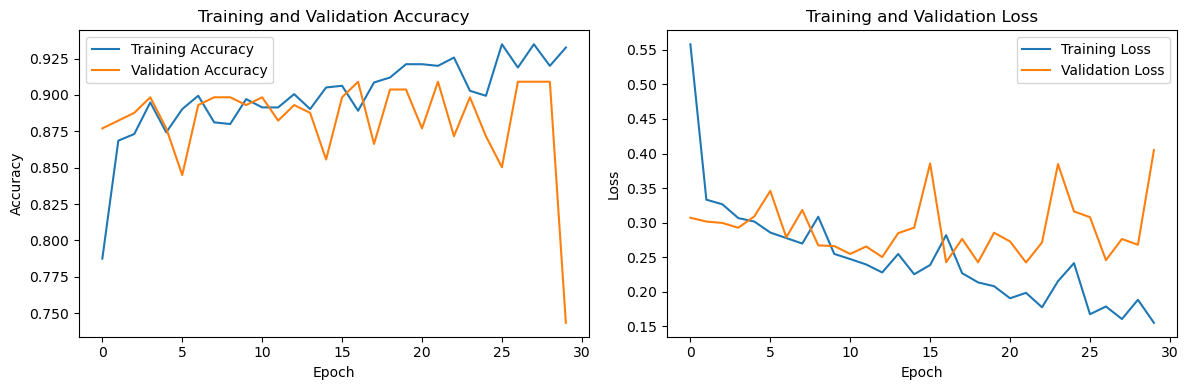


Confusion Matrix:


2025-08-23 10:57:51.814992: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


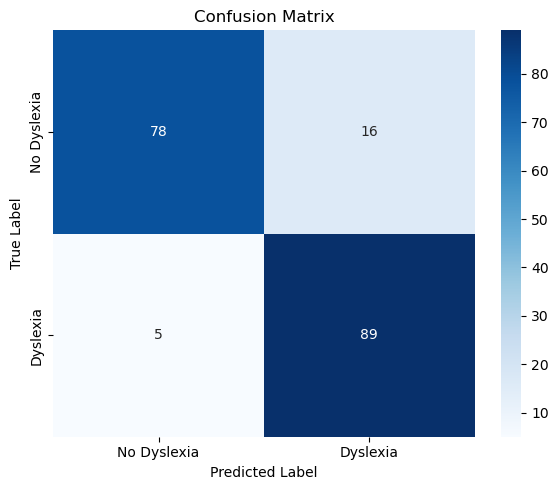


Additional Metrics for Test Results:
Sensitivity (Recall): 0.9468
Specificity: 0.8298
F1 Score: 0.8945

Classification Report:
              precision    recall  f1-score   support

 No Dyslexia       0.94      0.83      0.88        94
    Dyslexia       0.85      0.95      0.89        94

    accuracy                           0.89       188
   macro avg       0.89      0.89      0.89       188
weighted avg       0.89      0.89      0.89       188

ROC AUC Score (Prob-based): 0.9399
PR AUC Score: 0.9159


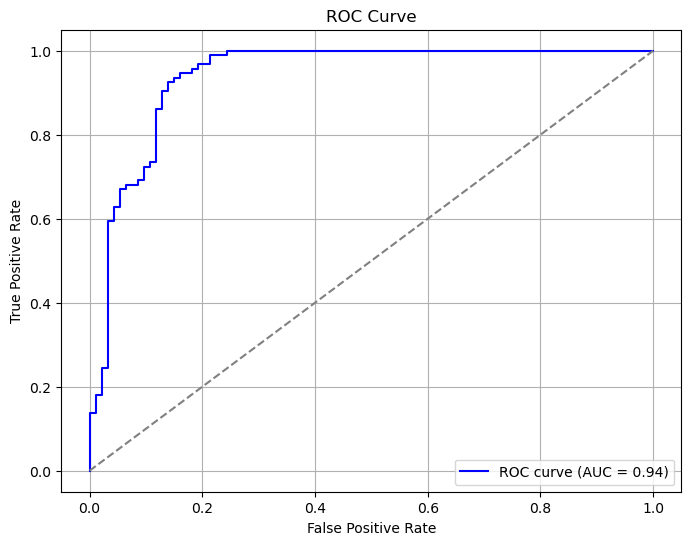

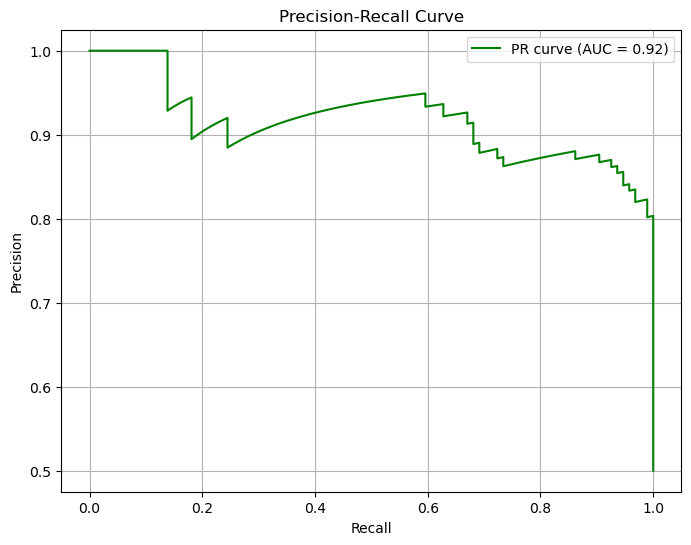

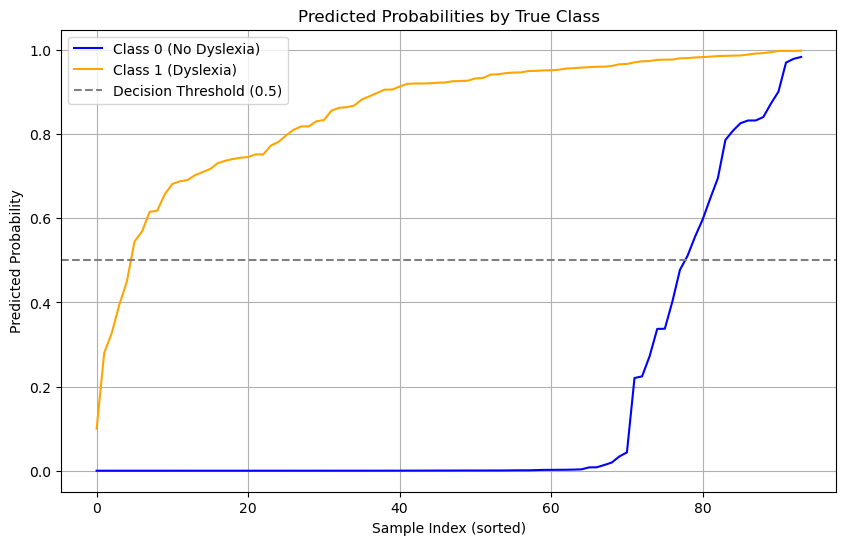

In [11]:
# Load new dataset 
# ---  Data Loading from CSV ---
# Load CSV file for the new generated motor dysgraphia dataset 
try:
    df_dysgraphia = pd.read_csv('../handwriting_generation/dyslexia_and_dysgraphia_handwriting_dataset.csv')
    print("--- Successfully loaded dyslexia_and_dysgraphia_handwriting_dataset.csv ---")
except FileNotFoundError:
    print("Error: 'dyslexia_and_dysgraphia_handwriting_dataset.csv' not found. Please ensure the CSV file is in the same directory as the script.")
    exit()

# Check CSV has 'file_path', 'text', and 'presence_of_dyslexia' columns
if 'file_path' not in df_dysgraphia.columns or 'text' not in df_dysgraphia.columns or 'presence_of_dyslexia' not in df.columns:
    print("Error: CSV must contain 'file_path', 'text', and 'presence_of_dyslexia' columns.")
    exit()

# Convert labels to integer type
df_dysgraphia['presence_of_dyslexia'] = df_dysgraphia['presence_of_dyslexia'].astype(int)

print("--- DataFrame Head ---")
print(df_dysgraphia.head())
print("\n--- Value Counts for Dyslexia Presence ---")
print(df_dysgraphia['presence_of_dyslexia'].value_counts())

df_dysgraphia['text'] = df_dysgraphia['text'].fillna('').astype(str) # Fill NaN with empty string, then convert to str
print(f"Total samples: {len(df_dysgraphia)}")

print("Current working directory: ", os.getcwd())
# --- Image Preprocessing (Pre-loading all images) ---
print("Loading and preprocessing all images...")
all_dysgraphia_images = []
for index, row in df_dysgraphia.iterrows():
    image_path = row['file_path']
    full_image_path = image_path
    try:
        # Load image file
        img = tf.io.read_file(full_image_path)
        # Decode image 
        img = tf.image.decode_jpeg(img, channels=3)  
        # Resize image
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        # Apply ResNet50 specific preprocessing
        img = tf.keras.applications.resnet50.preprocess_input(img)
        all_dysgraphia_images.append(img)
    except Exception as e:
        print(f"Error loading image {full_image_path}: {e}. Appending black image placeholder.")
        all_dysgraphia_images.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32))

all_dysgraphia_images = np.array(all_dysgraphia_images)
print(f"All dysgraphia_images loaded. Shape: {all_dysgraphia_images.shape}")

# Split into training and (validation + test)
train_df_image_dysgraphia, val_test_df_image_dysgraphia = train_test_split(
    df_dysgraphia,
    test_size=0.3, 
    stratify=df_dysgraphia['presence_of_dyslexia'], # Maintain class distribution
    random_state=seed
)

# Then, split (validation + test) into validation and test
val_df_image_dysgraphia, test_df_image_dysgraphia = train_test_split(
    val_test_df_image_dysgraphia,
    test_size=0.5, 
    stratify=val_test_df_image_dysgraphia['presence_of_dyslexia'], # Maintain class distribution
    random_state=seed
)

train_image_dysgraphia_dataset = create_dataset(train_df_image_dysgraphia, augment=False, shuffle=True)
validation_image_dysgraphia_dataset = create_dataset(val_df_image_dysgraphia, augment=False, shuffle=False)
test_image_dysgraphia_dataset = create_dataset(test_df_image_dysgraphia, augment=False, shuffle=False)

combined_train_image_dysgraphia_dataset = train_dataset_image.concatenate(train_image_dysgraphia_dataset)
combined_validation_image_dysgraphia_dataset = validation_dataset_image.concatenate(validation_image_dysgraphia_dataset)
combined_test_image_dysgraphia_dataset = test_dataset_image.concatenate(test_image_dysgraphia_dataset)
combined_train_image_dysgraphia_dataset = combined_train_image_dysgraphia_dataset.shuffle(buffer_size=1000)
combined_validation_image_dysgraphia_dataset = combined_validation_image_dysgraphia_dataset.shuffle(buffer_size=1000)
combined_test_image_dysgraphia_dataset = combined_test_image_dysgraphia_dataset.shuffle(buffer_size=1000)

# --- Model Building (ResNet50 for Binary Classification) ---
# Load ResNet50 model with pre-trained ImageNet weights, excluding the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model layers to prevent their weights from being updated during initial training.
# This uses the pre-learned features from ImageNet as-is.
base_model.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces spatial dimensions to 1x1, capturing global features
x = Dense(256, activation='relu')(x) # A dense layer before the final output
predictions = Dense(1, activation='sigmoid')(x) # Output layer for binary classification

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
# Using Adam optimizer, binary_crossentropy for binary classification, and accuracy as metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("\n--- Model Summary (Initial Frozen Layers) ---")
model.summary()

# --- Model Training ---

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
print(f"\n--- Training the model for {EPOCHS} epochs ---")
history = model.fit(
    combined_train_image_dysgraphia_dataset,
    epochs=EPOCHS,
    validation_data=combined_validation_image_dysgraphia_dataset,
    callbacks=[early_stopping_callback]
)

# ---  Model Evaluation ---
print("\n--- Evaluating the model on the test set ---")
test_loss, test_accuracy = model.evaluate(combined_test_image_dysgraphia_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# ---  Visualize Training History ---
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
# --- Gather predictions and true labels ---
all_probs = []
all_labels = []

for images, labels in combined_test_image_dysgraphia_dataset:
    probs = model.predict(images, verbose=0).flatten()
    all_probs.extend(probs)
    all_labels.extend(labels.numpy())

# --- Show final performance metrics ---
show_performance_metrics(all_labels, all_probs)

Loading BERT tokenizer and tokenizing all text...
All text tokenized. Input IDs shape: (250, 128), Attention Masks shape: (250, 128)


/config/anaconda3/envs/imperial_3_12_linux/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Training samples: 55
Validation samples: 10
TensorFlow Datasets created from preprocessed NumPy arrays.
Building multi-modal model architecture...
ResNet50 model loaded and layers frozen.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

BERT model wrapped in custom layer and layers frozen.
Compiling model...


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ image_input[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,473,345 (100.99 MB)

 Trainable params: 2,885,633 (11.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Training model...
Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 44s 692ms/step - accuracy: 0.7715 - loss: 0.4318 - val_accuracy: 0.9519 - val_loss: 0.1380
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 665ms/step - accuracy: 0.9380 - loss: 0.1371 - val_accuracy: 0.9572 - val_loss: 0.1032
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 663ms/step - accuracy: 0.9577 - loss: 0.1172 - val_accuracy: 0.9572 - val_loss: 0.0943
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 664ms/step - accuracy: 0.9726 - loss: 0.0860 - val_accuracy: 0.9679 - val_loss: 0.0798
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 664ms/step - accuracy: 0.9570 - loss: 0.1045 - val_accuracy: 0.9786 - val_loss: 0.0729
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 663ms/step - accuracy: 0.9655 - loss: 0.0851 - val_accuracy: 0.9305 - val_loss: 0.1354
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 663ms/step - accuracy: 0.9748 - loss: 0.0734 - val_accuracy: 0.9679 - val_loss: 0.0726
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 663ms/step - accuracy: 0.9623 - loss:

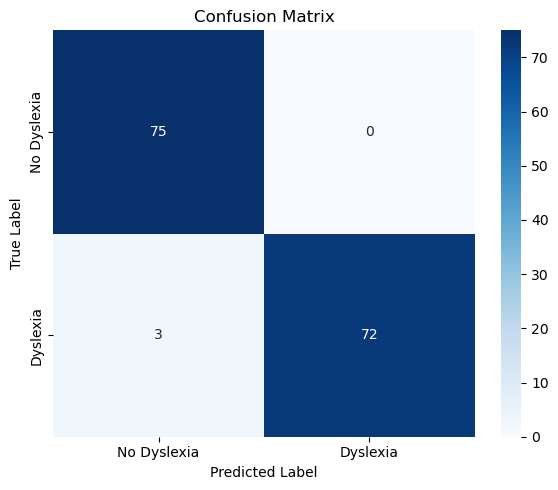


Additional Metrics for Test Results:
Sensitivity (Recall): 0.9600
Specificity: 1.0000
F1 Score: 0.9796

Classification Report:
              precision    recall  f1-score   support

 No Dyslexia       0.96      1.00      0.98        75
    Dyslexia       1.00      0.96      0.98        75

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150

ROC AUC Score (Prob-based): 0.9998
PR AUC Score: 0.9998


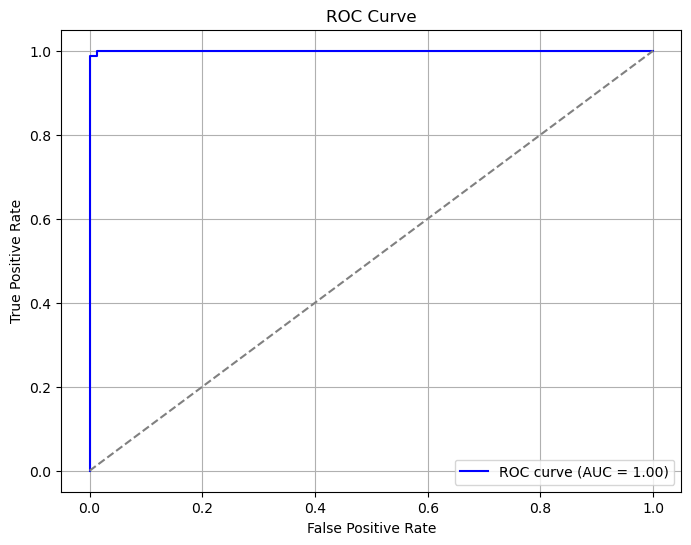

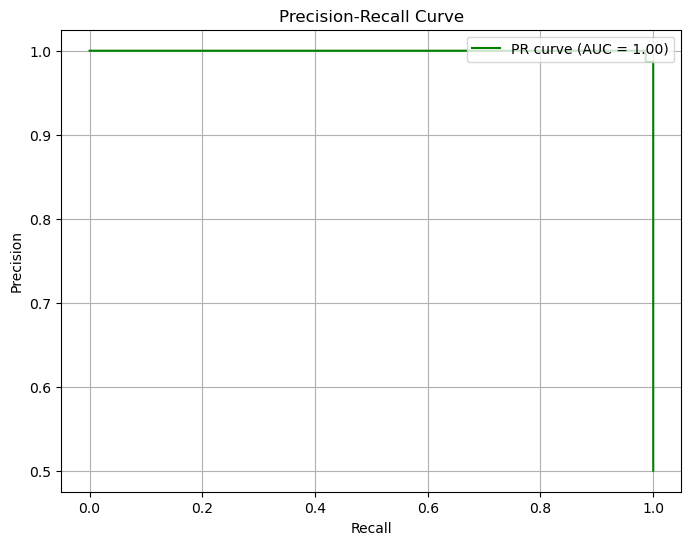

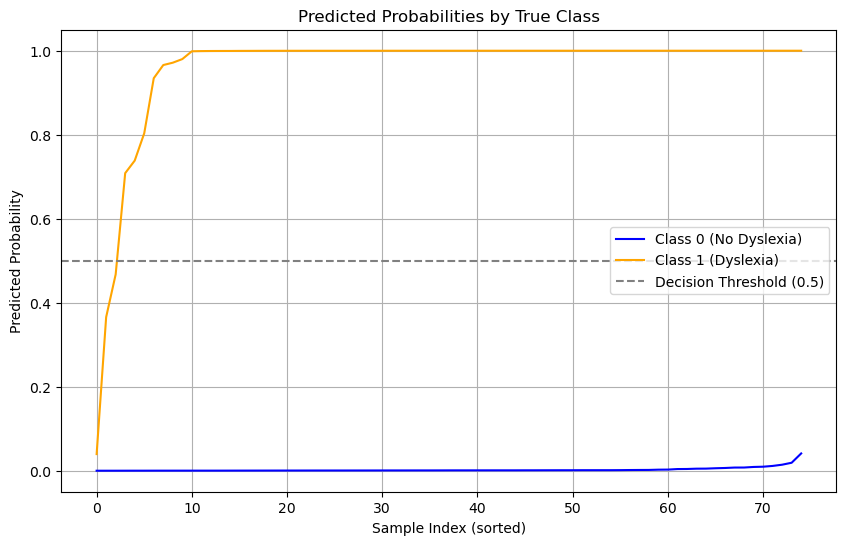


Model training and evaluation complete.

Evaluating model on Dysgraphia Test set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step - accuracy: 0.9790 - loss: 0.1131
Test Loss: 0.1387
Test Accuracy: 0.9737
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.95      0.97        19

    accuracy                           0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.97      0.97      0.97        38


Confusion Matrix:
[[19  0]
 [ 1 18]]

Confusion Matrix:


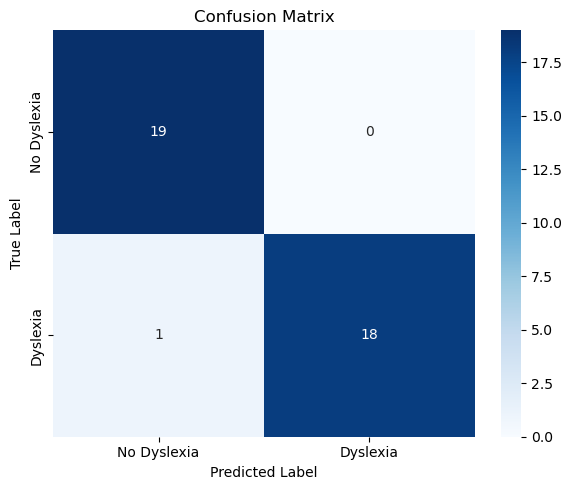


Additional Metrics for Test Results:
Sensitivity (Recall): 0.9474
Specificity: 1.0000
F1 Score: 0.9730

Classification Report:
              precision    recall  f1-score   support

 No Dyslexia       0.95      1.00      0.97        19
    Dyslexia       1.00      0.95      0.97        19

    accuracy                           0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.97      0.97      0.97        38

ROC AUC Score (Prob-based): 0.9612
PR AUC Score: 0.9773


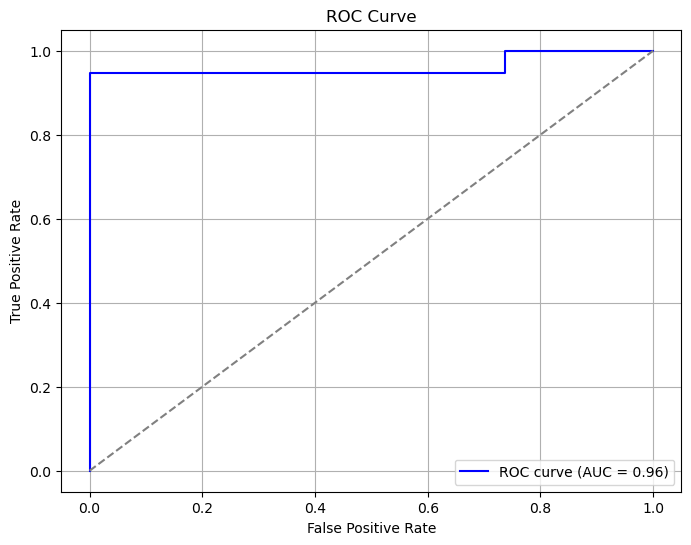

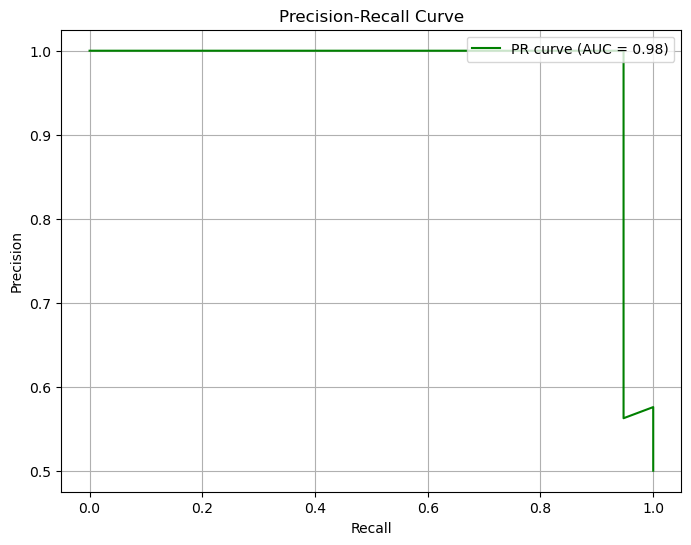

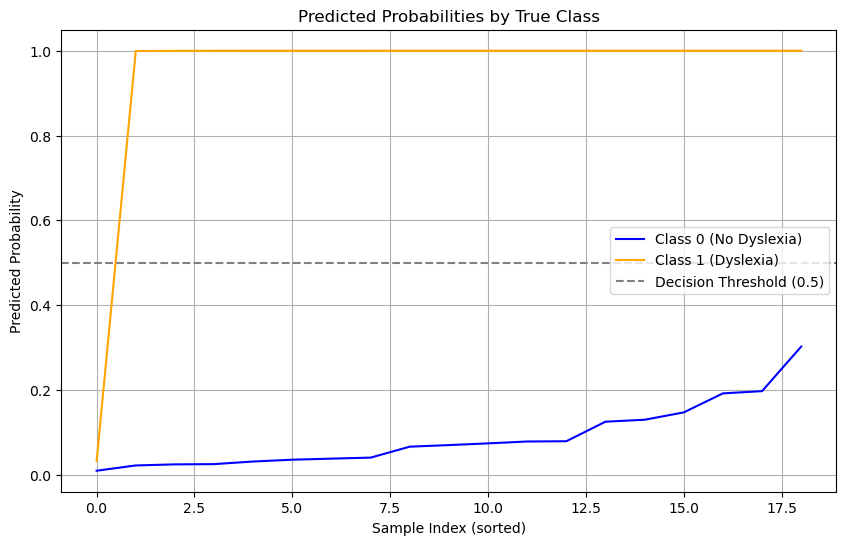


Model training and evaluation complete.


In [12]:
# --- Text Tokenization (Pre-tokenizing all text) ---
print("Loading BERT tokenizer and tokenizing all text...")
dysgraphia_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

all_dysgraphia_input_ids = []
all_dysgraphia_attention_masks = []

for text_entry in df_dysgraphia['text']:
    encoded_input = dysgraphia_tokenizer(
        text_entry,
        padding='max_length',
        truncation=True,
        max_length=128, # Consistent max length
        return_tensors='np'
    )
    # Crucial change: Access the first (and only) item in the batch dimension [0]
    all_dysgraphia_input_ids.append(encoded_input['input_ids'][0])
    all_dysgraphia_attention_masks.append(encoded_input['attention_mask'][0])

all_dysgraphia_input_ids = np.array(all_dysgraphia_input_ids)
all_dysgraphia_attention_masks = np.array(all_dysgraphia_attention_masks)
print(f"All text tokenized. Input IDs shape: {all_dysgraphia_input_ids.shape}, Attention Masks shape: {all_dysgraphia_attention_masks.shape}")

# Split into Training (70%) and Temporary (30%)

X_images_train_dysgraphia, X_images_temp_dysgraphia, \
X_input_ids_train_dysgraphia, X_input_ids_temp_dysgraphia, \
X_attention_masks_train_dysgraphia, X_attention_masks_temp_dysgraphia, \
y_train_dysgraphia, y_temp_dysgraphia = train_test_split(
    all_dysgraphia_images,
    all_dysgraphia_input_ids,
    all_dysgraphia_attention_masks,
    df_dysgraphia['presence_of_dyslexia'].values,
    test_size=0.3,  # 30% for temp set (which will become val + test)
    random_state=seed,
    stratify=df_dysgraphia['presence_of_dyslexia'].values
)

#  Split the Temporary set (30%) into Validation (15%) and Test (15%)
X_images_val_dysgraphia, X_images_test_dysgraphia, \
X_input_ids_val_dysgraphia, X_input_ids_test_dysgraphia, \
X_attention_masks_val_dysgraphia, X_attention_masks_test_dysgraphia, \
y_val_dysgraphia, y_test_dysgraphia = train_test_split(
    X_images_temp_dysgraphia,
    X_input_ids_temp_dysgraphia,
    X_attention_masks_temp_dysgraphia,
    y_temp_dysgraphia,
    test_size=0.5,  # 50% of the temp set (0.5 * 0.3 = 0.15 = 15%)
    random_state=seed, # Keep the same random_state for reproducibility
    stratify=y_temp_dysgraphia # Stratify based on the labels of the temp set
)

train_dysgraphia_dataset = create_tf_dataset_from_np(X_images_train_dysgraphia, X_input_ids_train_dysgraphia, X_attention_masks_train_dysgraphia, y_train_dysgraphia, augment=False, shuffle=True)
val_dysgraphia_dataset = create_tf_dataset_from_np(X_images_val_dysgraphia, X_input_ids_val_dysgraphia, X_attention_masks_val_dysgraphia, y_val_dysgraphia, augment=False)
test_dysgraphia_dataset = create_tf_dataset_from_np(X_images_test_dysgraphia, X_input_ids_test_dysgraphia, X_attention_masks_test_dysgraphia, y_test_dysgraphia, augment=False)

# Concat the training and validation with the original datasets
combined_train_dataset = train_dataset.concatenate(train_dysgraphia_dataset)
combined_train_dataset = combined_train_dataset.shuffle(buffer_size=1000)
combined_val_dataset = val_dataset.concatenate(val_dysgraphia_dataset)
combined_val_dataset = combined_val_dataset.shuffle(buffer_size=1000)

print(f"Training samples: {combined_train_dataset.cardinality().numpy()}")
print(f"Validation samples: {val_dataset.cardinality().numpy()}")
# print(f"Test samples: {len(y_val)}")

print("TensorFlow Datasets created from preprocessed NumPy arrays.")

# --- Define the Multi-Modal Model ---
print("Building multi-modal model architecture...")

# Image Branch (ResNet50)
resnet_input = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='image_input')
resnet_model = keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=resnet_input
)

# Freeze ResNet50 layers
resnet_model.trainable = False
print("ResNet50 model loaded and layers frozen.")

# Extract features from ResNet50 output
image_features = resnet_model.output
image_features = layers.GlobalAveragePooling2D()(image_features)

# Text Branch (BERT) using the custom layer
bert_input_ids = keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
bert_attention_mask = keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

bert_embedding_extractor = BertEmbeddingLayer("bert-base-cased", name="bert_feature_extractor")
text_features = bert_embedding_extractor({'input_ids': bert_input_ids, 'attention_mask': bert_attention_mask})
print("BERT model wrapped in custom layer and layers frozen.")

# Concatenate features from both modalities
concatenated_features = layers.Concatenate()([image_features, text_features])

# Classifier Head (New layers to be trained)
# Late fusion: combine the two modalities, decided 1024 , as we have the feature vectors as 2048 (image) + 768 (text)
fusion = layers.Dense(1024, activation='relu')(concatenated_features)
fusion = layers.Dropout(0.5)(fusion)
# Final binary classification
output_layer = layers.Dense(1, activation='sigmoid', name='output')(fusion)

# Create the final multi-modal model
model = keras.Model(
    inputs={'image_input': resnet_input, 'input_ids': bert_input_ids, 'attention_mask': bert_attention_mask},
    outputs=output_layer
)

# --- Compile and Train the Model ---
print("Compiling model...")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

model.summary()

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("Training model...")
history = model.fit(
    combined_train_dataset,
    epochs=EPOCHS,
    validation_data=combined_val_dataset,
    callbacks=[early_stopping_callback]
)

# --- Evaluation ---
print("\nEvaluating model on Test set...")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions and classification report
all_preds = []
all_labels = []
# Create a dataset for prediction from validation data
predict_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {'image_input': X_images_test, 'input_ids': X_input_ids_test, 'attention_mask': X_attention_masks_test},
        y_test
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for inputs, labels in predict_dataset:
    predictions = model.predict(inputs)
    all_preds.extend(predictions.flatten().tolist())
    all_labels.extend(labels.numpy().flatten().tolist())

# Convert probabilities to binary predictions (0 or 1)
binary_preds = np.array(all_preds) > 0.5

print("\nClassification Report:")
print(classification_report(all_labels, binary_preds))

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, binary_preds))

# --- Show final performance metrics ---
show_performance_metrics(all_labels, all_preds)

print("\nModel training and evaluation complete.")

# --- Evaluation ---
print("\nEvaluating model on Dysgraphia Test set...")
test_loss, test_accuracy = model.evaluate(test_dysgraphia_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions and classification report
all_preds = []
all_labels = []
# Create a dataset for prediction from validation data
predict_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {'image_input': X_images_test_dysgraphia, 'input_ids': X_input_ids_test_dysgraphia, 'attention_mask': X_attention_masks_test_dysgraphia},
        y_test_dysgraphia
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for inputs, labels in predict_dataset:
    predictions = model.predict(inputs)
    all_preds.extend(predictions.flatten().tolist())
    all_labels.extend(labels.numpy().flatten().tolist())

# Convert probabilities to binary predictions (0 or 1)
binary_preds = np.array(all_preds) > 0.5

print("\nClassification Report:")
print(classification_report(all_labels, binary_preds))

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, binary_preds))

# --- Show final performance metrics ---
show_performance_metrics(all_labels, all_preds)

print("\nModel training and evaluation complete.")
